In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import sys
import torch
import random
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib

%matplotlib inline

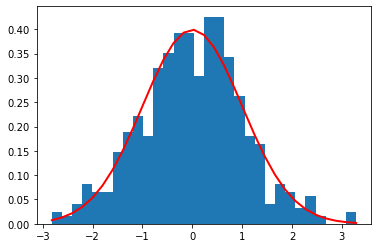

In [2]:
mu1 = 0
sigma1 = 1
A = np.random.normal(mu1, sigma1, 600)
count, bins, ignored = plt.hist(A, 30, density=True)
plt.plot(bins, 1/(sigma1 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu1)**2 / (2 * sigma1**2) ),
         linewidth=2, color='r')
plt.show()

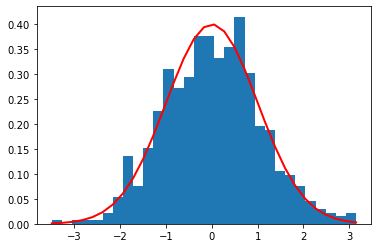

In [3]:
mu2 = 0
sigma2 = 1
B = np.random.normal(mu2, sigma2, 600)
count, bins, ignored = plt.hist(B, 30, density=True)
plt.plot(bins, 1/(sigma2 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu2)**2 / (2 * sigma2**2) ),
         linewidth=2, color='r')
plt.show()

In [4]:
data = np.vstack((A, B))
data = data.transpose()
df = pd.DataFrame(data = data, index=list(range(600)), columns = ['A', 'B'])
df['Y'] = 0 #default is health

In [5]:
df.head(5)

,A,B,Y
0,-2.193420,-0.927766,0
1,-0.801195,0.636001,0
2,-0.404160,2.522074,0
3,-0.776348,0.029055,0
4,-0.014683,1.022358,0


In [6]:
A_ = 0.54
B_ = 0.54

# The possible of unhealthy subsets

- case 1: feature A > 0.54 (30%)
- case 2: feature B > 0.54 (30%)

In [7]:
df.iloc[(df.A > A_) | ((df.B > B_)), 2] = 1

In [8]:
df.head(20)

,A,B,Y
0,-2.193420,-0.927766,0
1,-0.801195,0.636001,1
2,-0.404160,2.522074,1
3,-0.776348,0.029055,0
4,-0.014683,1.022358,1
5,-1.139635,0.476476,0
6,-0.773311,1.140425,1
7,1.138393,-0.074017,1
8,0.293793,1.234495,1
9,-0.141224,0.825986,1


In [9]:
data = df.to_numpy()

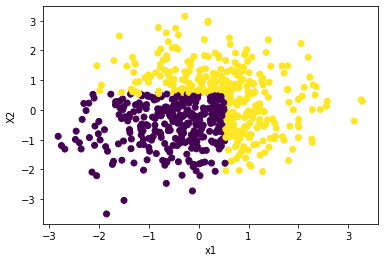

In [10]:
plt.scatter(data[:, 0], data[:, 1], c = data[:, 2])
plt.xlabel("x1")
plt.ylabel("X2")
plt.show()

In [11]:
#df.to_csv("synthetic_data_simple.csv", header = False, index = False)

In [12]:
(df.Y == 0).sum()

294

In [13]:
(df.Y == 1).sum()

306

In [14]:
dataset = df.to_numpy().astype(np.float32)
train, val, test = dataset[0:300, ], dataset[300:450, ], dataset[450:600, ]
train_x, train_y = train[:, 0:2], train[:, 2:3]
val_x, val_y = val[:, 0:2], val[:, 2:3]
test_x, test_y = test[:, 0:2], test[:, 2:3]
DTrain = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
DVal = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
DTest = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(DTrain, batch_size = 32) 
val_loader = DataLoader(DVal, batch_size = 32) 
test_loader = DataLoader(DTest, batch_size = 32)

In [15]:
def epoch_train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc

def epoch_val(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for  batch_idx, (data, target) in enumerate(iterator):
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    return epoch_loss / len(iterator.dataset), acc


In [16]:
model = nn.Sequential(
        nn.Linear(2, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
        nn.Sigmoid(),
        )

#optimizer = optim.SGD(model.parameters(), lr = 0.02)
optimizer = optim.Adam(model.parameters(), lr = 0.02)
criterion = nn.BCELoss()
device = torch.device("cpu")
model = model.to(device)
criterion = criterion.to(device)

best_model = None
best_acc = -float('inf')


for epoch in range(5):
    train_loss, train_acc = epoch_train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = epoch_val(model, val_loader, criterion, device)

    if valid_acc > best_acc:
        best_model = copy.deepcopy(model)
        best_acc = valid_acc

    if epoch % 5 == 0:
        print(f"Epoch : {epoch} | Train Loss: {train_loss:.3f} | Train acc: {train_acc:.3f}")
        print(f"Epoch : {epoch} | Val. Loss: {valid_loss:.3f} | Val acc: {valid_acc:.3f}")

test_loss, test_acc = epoch_val(best_model, test_loader, criterion, device)
print(f"Test. Loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")
torch.save(best_model, "synthetic_model_simple.pt")


Epoch : 0 | Train Loss: 0.568 | Train acc: 0.747
Epoch : 0 | Val. Loss: 0.401 | Val acc: 0.853
Epoch : 5 | Train Loss: 0.092 | Train acc: 0.990
Epoch : 5 | Val. Loss: 0.099 | Val acc: 0.973
Test. Loss: 0.066 | Test acc: 0.987


# Plot contour lines

In [27]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X1, X2 = np.meshgrid(xlist, ylist)

In [28]:
Z = np.c_[X1.ravel(), X2.ravel()]

In [29]:
test_data = torch.from_numpy(Z.astype(np.float32))

In [30]:
Y = best_model(test_data).detach().numpy()

In [31]:
Y = Y.reshape(X1.shape)

In [32]:
xlist1 = np.linspace(-3.0, 3.0, 20)
ylist1 = np.linspace(-3.0, 3.0, 20)
X1_, X2_ = np.meshgrid(xlist1, ylist1)
Z_ = np.c_[X1_.ravel(), X2_.ravel()]
test_data_ = torch.from_numpy(Z_.astype(np.float32))
test_data_.requires_grad_(True)
output = best_model(test_data_)
output.sum().backward()


In [33]:
gradient = test_data_.grad

In [34]:
np_gradient = gradient.detach().numpy()
np_gradient = np_gradient.reshape(20, 20, 2)

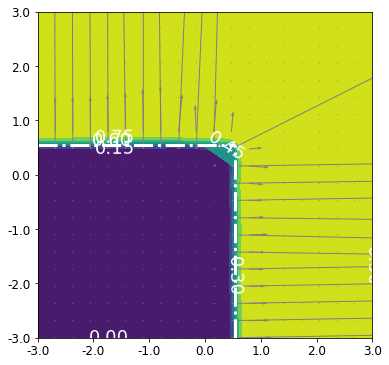

In [35]:
from matplotlib.ticker import FormatStrFormatter
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 6)
CS = ax.contourf(X1, X2, Y)#, cmap=plt.cm.PuBu)
ax.quiver(X1_, X2_, np_gradient[:,:, 0], np_gradient[:,:, 1], units='xy', scale=0.5, color='gray')
ax.clabel(CS, fontsize=18, inline=2, colors = 'white')
ax.plot([-3.0, 0.54], [0.54, 0.54], linestyle = '-.', linewidth = 3, color = 'white')
ax.plot([0.54, 0.54], [-3, 0.54], linestyle = '-.', linewidth = 3, color = 'white')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))